In [1]:
import pandas as pd
import miceforest as mf
import numpy as np

In [2]:
# Load the data
df = pd.read_csv("../data/modified_numeric.csv")

In [3]:
df.columns

Index(['n_cycles_trying', 'outcome_pregnant', 'bmi', 'age',
       'education_numeric', 'been_pregnant_before_numeric',
       'sleeping_pattern_numeric', 'average_cycle_length', 'cycle_length_std',
       'intercourse_frequency', 'dedication'],
      dtype='object')

In [4]:
# Separate target variables (do NOT impute these)
targets = df[['n_cycles_trying', 'outcome_pregnant']]
features = df.drop(columns=['n_cycles_trying', 'outcome_pregnant']) # regular_cycle is derived from cycle_lenght_std and I don't want to use country

In [5]:
# Convert object to category
for col in features.select_dtypes(include='object'):
    print('category')
    features[col] = features[col].astype('category')

In [6]:
features = features.reset_index(drop=True)

In [7]:
numeric_features = features.select_dtypes(include=[np.number])

# Now safely check for inf and nan
print("Infinite values:", np.isinf(numeric_features.to_numpy()).sum())
print("NaN values:", np.isnan(numeric_features.to_numpy()).sum())
print("NaN count by column:")
print(numeric_features.isna().sum())

Infinite values: 0
NaN values: 1238
NaN count by column:
bmi                               0
age                               0
education_numeric               391
been_pregnant_before_numeric    317
sleeping_pattern_numeric        499
average_cycle_length              6
cycle_length_std                 25
intercourse_frequency             0
dedication                        0
dtype: int64


In [8]:
# Initialize kernel
kernel = mf.ImputationKernel(
    data=features,
    random_state=100,
    save_all_iterations_data=True,
    num_datasets=1
)

In [9]:
print(mf.__version__)

6.0.3


In [10]:
# Perform MICE
kernel.mice(
    iterations=50
)

In [11]:
imputed_df = kernel.complete_data(dataset=0)

In [12]:
mask = (df[imputed_df.columns] != imputed_df)

In [13]:
# Imputed values
imputed_df[mask].describe()

,bmi,age,education_numeric,been_pregnant_before_numeric,sleeping_pattern_numeric,average_cycle_length,cycle_length_std,intercourse_frequency,dedication
count,0.0,0.0,391.000000,317.000000,499.000000,6.000000,25.000000,0.0,0.0
mean,NaN,NaN,2.744246,0.561514,2.152305,34.152740,6.801801,NaN,NaN
std,NaN,NaN,0.765313,0.819174,1.322059,12.661793,8.723071,NaN,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,25.588235,0.792961,NaN,NaN
25%,NaN,NaN,3.000000,0.000000,1.000000,27.640385,2.136976,NaN,NaN
50%,NaN,NaN,3.000000,0.000000,3.000000,28.980769,3.300884,NaN,NaN
75%,NaN,NaN,3.000000,1.000000,3.000000,33.500000,7.719119,NaN,NaN
max,NaN,NaN,4.000000,3.000000,4.000000,59.166667,41.126634,NaN,NaN


In [14]:
# original values
imputed_df[~mask].describe()

,bmi,age,education_numeric,been_pregnant_before_numeric,sleeping_pattern_numeric,average_cycle_length,cycle_length_std,intercourse_frequency,dedication
count,1995.000000,1995.000000,1604.000000,1678.000000,1496.000000,1989.000000,1970.000000,1995.000000,1995.000000
mean,23.357643,31.898747,2.789900,0.430870,2.405749,30.530185,4.465253,0.106986,0.475641
std,4.982275,4.063534,0.813254,0.787303,1.312841,7.010407,8.675280,0.105248,0.335528
min,0.000000,19.000000,0.000000,0.000000,0.000000,19.500000,0.000000,0.000000,0.000000
25%,20.708276,29.000000,3.000000,0.000000,1.000000,27.176471,1.718249,0.020000,0.132567
50%,22.530864,32.000000,3.000000,0.000000,3.000000,29.000000,2.542727,0.080214,0.505415
75%,25.303154,35.000000,3.000000,1.000000,3.000000,31.666667,4.272002,0.162195,0.780816
max,50.611299,44.000000,4.000000,3.000000,4.000000,145.500000,168.998521,0.793103,1.347826


In [15]:
imputed_df[mask]['average_cycle_length']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1990   NaN
1991   NaN
1992   NaN
1993   NaN
1994   NaN
Name: average_cycle_length, Length: 1995, dtype: float64

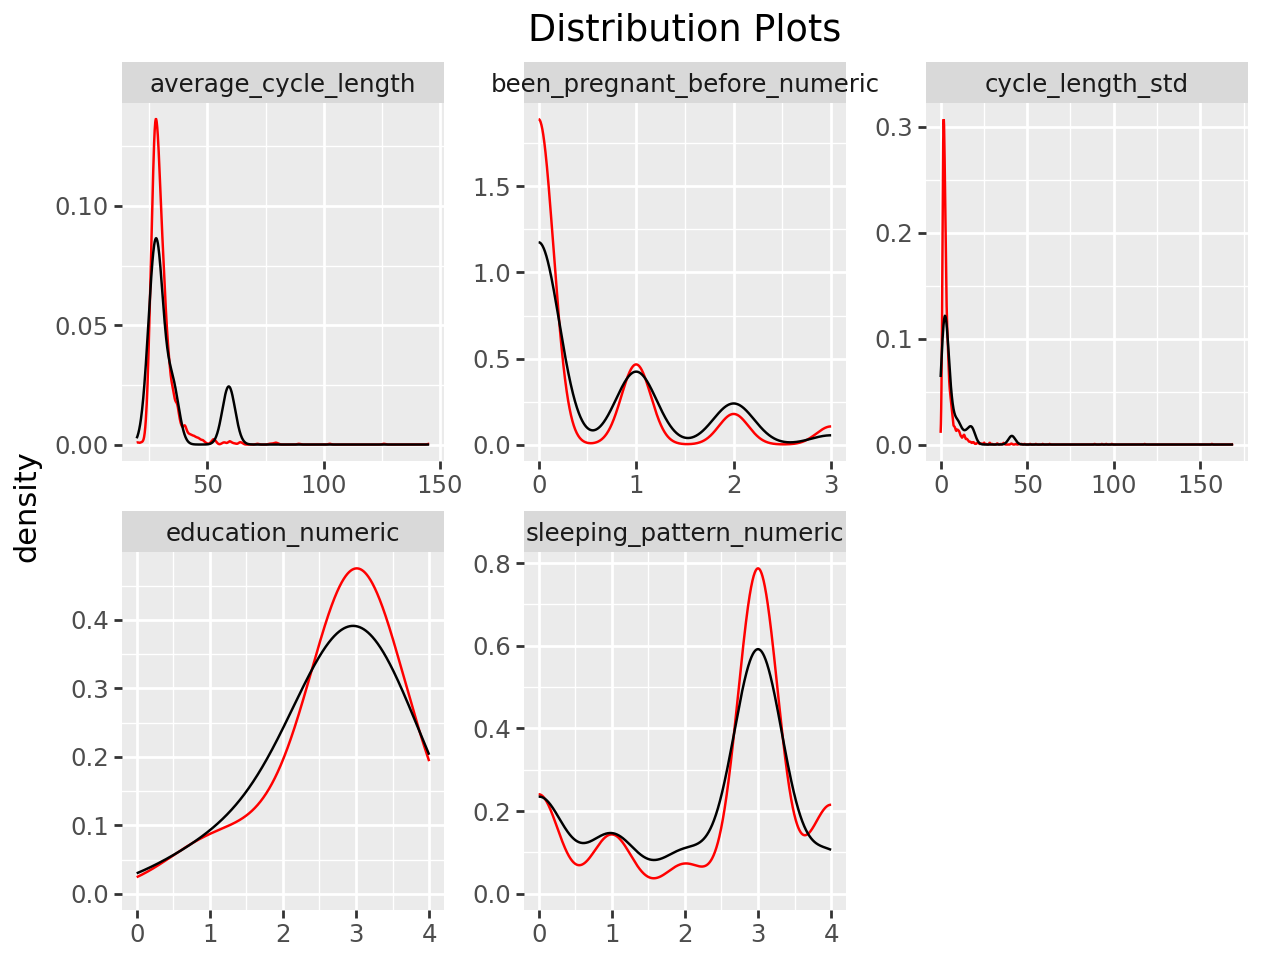

In [16]:
kernel.plot_imputed_distributions()

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence(kernel, df_original, variable: str, dataset: int = 0):
    """
    Plot the mean of imputed values for a given variable over iterations.
    Uses complete_data() in miceforest v5+.
    """
    if variable not in df_original.columns:
        raise ValueError(f"'{variable}' not found in original dataframe.")

    # Get indices where the original data was missing
    missing_idx = df_original[df_original[variable].isnull()].index
    if len(missing_idx) == 0:
        raise ValueError(f"No missing values in '{variable}' to track convergence.")

    means = []
    n_iters = kernel.iteration_count()

    for i in range(n_iters):
        # Get completed data at this iteration
        df_iter = kernel.complete_data(dataset=dataset, iteration=i)

        # Extract just the imputed values (originally missing)
        imputed_vals = df_iter.loc[missing_idx, variable]

        # Compute mean
        means.append(np.mean(imputed_vals))

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, n_iters + 1), means, marker='o')
    plt.title(f"Convergence of Mean Imputation for '{variable}'")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Imputed Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


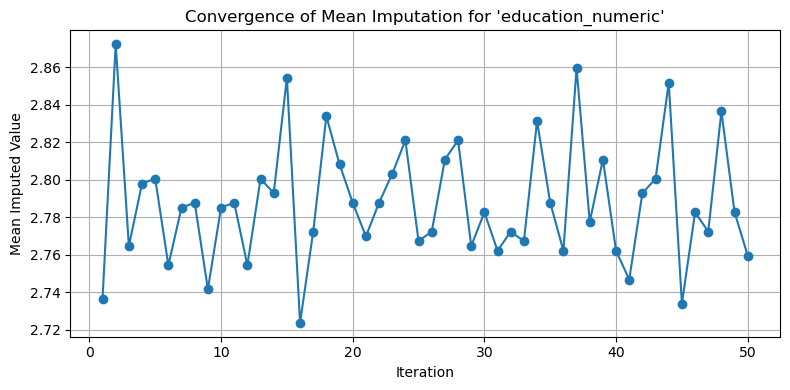

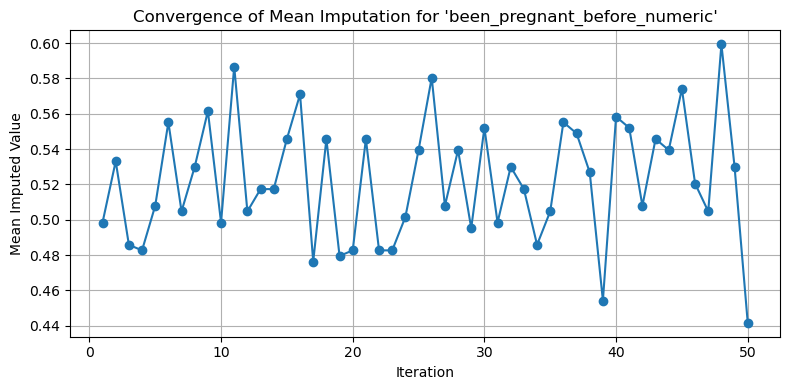

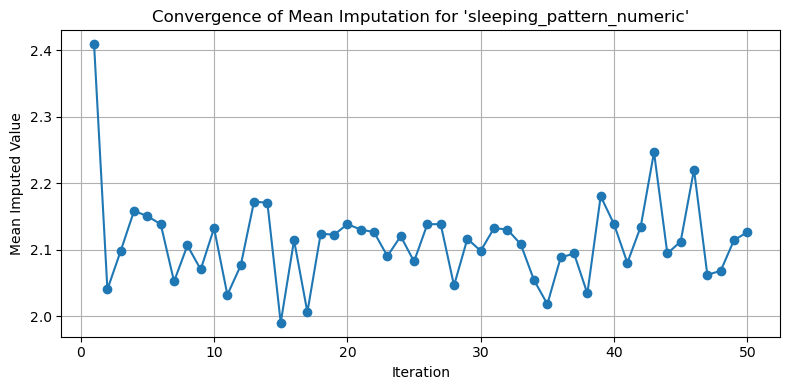

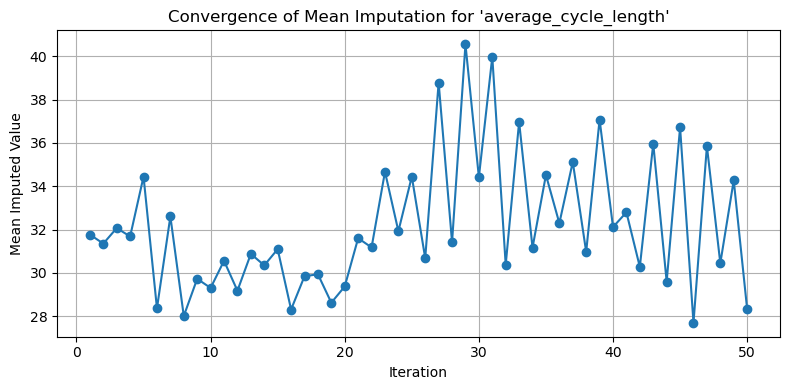

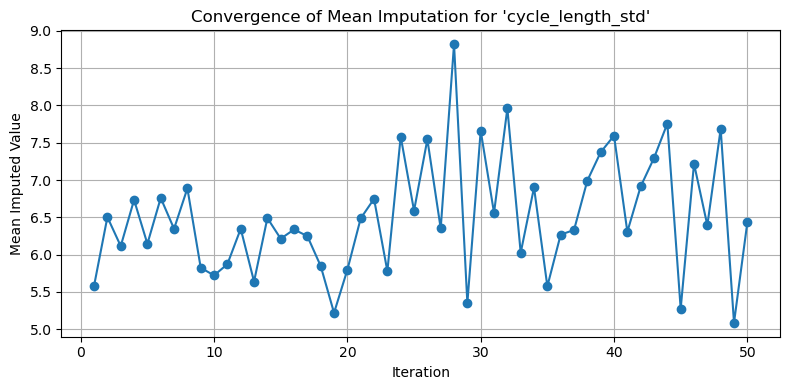

In [18]:
for col in features.columns:
    if features[col].isna().sum()>0:
        plot_convergence(kernel, features, col)

In [19]:
def compute_convergence_delta(kernel, df_original, variable: str, dataset: int = 0):
    missing_idx = df_original[df_original[variable].isnull()].index
    n_iters = kernel.iteration_count()
    means = []

    for i in range(n_iters):
        df_iter = kernel.complete_data(dataset=dataset, iteration=i)
        imputed_vals = df_iter.loc[missing_idx, variable]
        means.append(np.mean(imputed_vals))

    # Calculate relative change between iterations
    deltas = [
        abs((means[i] - means[i - 1]) / means[i - 1])
        for i in range(1, len(means))
    ]
    return deltas

In [20]:
deltas = compute_convergence_delta(kernel, features, "average_cycle_length")
print(deltas)

[np.float64(0.013220551999040448), np.float64(0.022910819602092534), np.float64(0.012060326892732462), np.float64(0.08736061592085302), np.float64(0.17684216851086443), np.float64(0.1498563959921674), np.float64(0.1411760128806985), np.float64(0.06145615589016835), np.float64(0.014251756467941046), np.float64(0.04283005196783679), np.float64(0.045221682053727806), np.float64(0.05834698454488453), np.float64(0.01719573473800164), np.float64(0.02469196961110303), np.float64(0.08971590678354485), np.float64(0.054286449928747926), np.float64(0.003097132690502907), np.float64(0.04393889109326766), np.float64(0.026303982196421542), np.float64(0.07591637877713858), np.float64(0.01352655019311404), np.float64(0.11219120862048967), np.float64(0.07923684605298968), np.float64(0.07905778278513256), np.float64(0.1095105243175678), np.float64(0.26473842277417997), np.float64(0.1902589387398814), np.float64(0.29126732806683625), np.float64(0.15146994081103546), np.float64(0.16166897697465804), np.fl

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_relative_change_convergence(kernel, df_original, variable: str, dataset: int = 0):
    """
    Plot the relative change in mean imputed values across iterations.
    """
    # Find indices with missing values in the original dataset
    missing_idx = df_original[df_original[variable].isnull()].index
    if len(missing_idx) == 0:
        raise ValueError(f"No missing values in '{variable}' to track convergence.")

    n_iters = kernel.iteration_count()
    means = []

    for i in range(n_iters):
        df_iter = kernel.complete_data(dataset=dataset, iteration=i)
        imputed_vals = df_iter.loc[missing_idx, variable]
        means.append(np.mean(imputed_vals))

    # Compute relative changes between iterations
    deltas = [
        abs((means[i] - means[i - 1]) / means[i - 1]) if means[i - 1] != 0 else 0
        for i in range(1, len(means))
    ]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, n_iters + 1), deltas, marker='o')
    plt.axhline(0.01, color='red', linestyle='--', label='1% threshold')
    plt.title(f"Relative Change in Mean Imputed Values for '{variable}'")
    plt.xlabel("Iteration")
    plt.ylabel("Relative Change (|Δμ/μ|)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return deltas


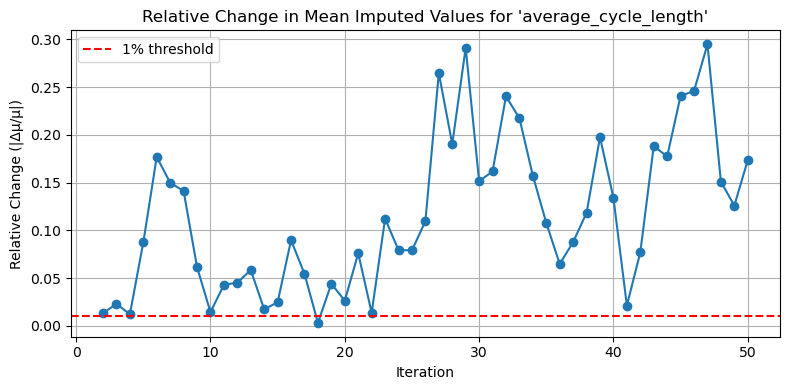

In [22]:
deltas = plot_relative_change_convergence(kernel, features, "average_cycle_length")


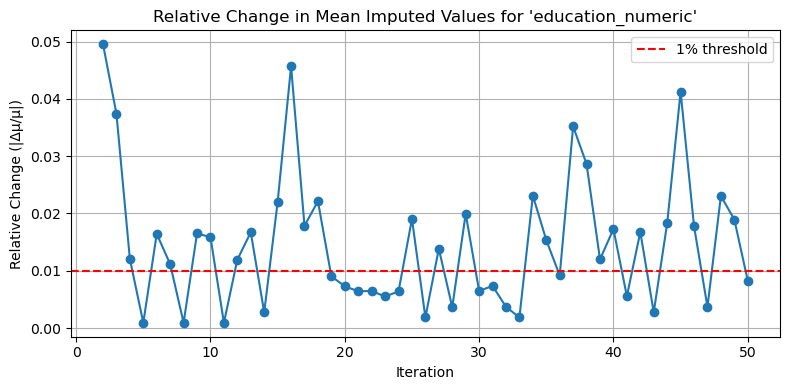

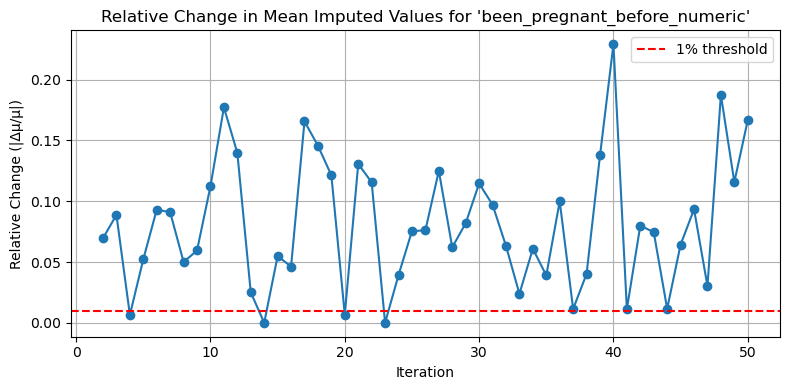

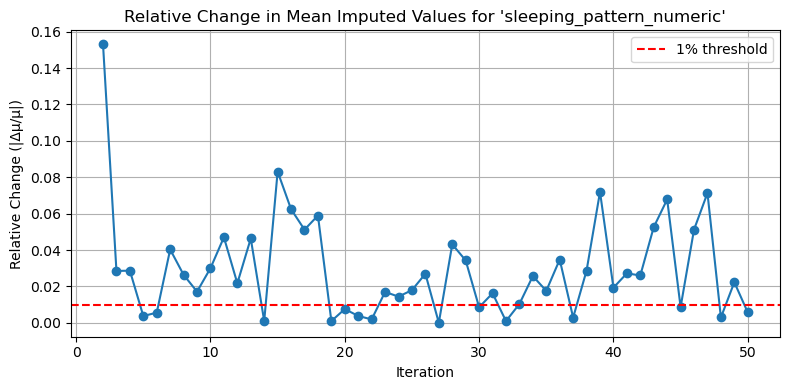

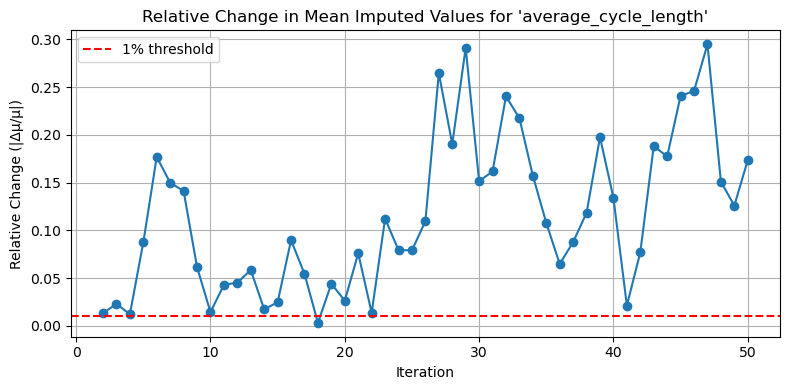

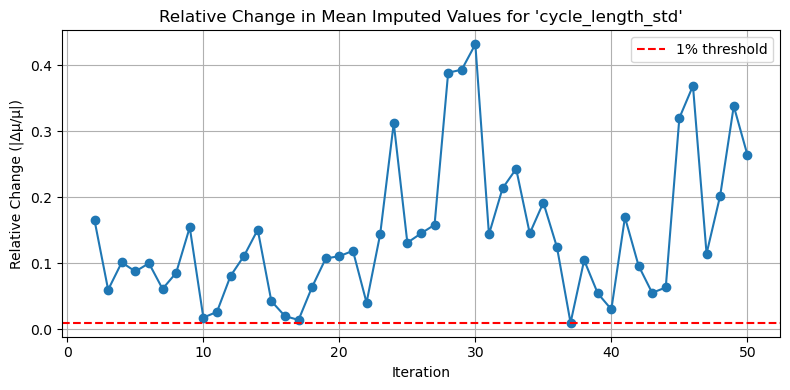

In [23]:
for col in features.columns:
    if features[col].isna().sum()>0:
        plot_relative_change_convergence(kernel, features, col)

In [24]:
def plot_relative_std_convergence(kernel, df_original, variable: str, dataset: int = 0):
    """
    Plot the relative change in std of imputed values across iterations.
    """
    missing_idx = df_original[df_original[variable].isnull()].index
    if len(missing_idx) == 0:
        raise ValueError(f"No missing values in '{variable}' to track convergence.")

    n_iters = kernel.iteration_count()
    stds = []

    for i in range(n_iters):
        df_iter = kernel.complete_data(dataset=dataset, iteration=i)
        imputed_vals = df_iter.loc[missing_idx, variable]
        stds.append(np.std(imputed_vals))

    # Compute relative changes between iterations
    deltas = [
        abs((stds[i] - stds[i - 1]) / stds[i - 1]) if stds[i - 1] != 0 else 0
        for i in range(1, len(stds))
    ]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, n_iters + 1), deltas, marker='o')
    plt.axhline(0.01, color='red', linestyle='--', label='1% threshold')
    plt.title(f"Relative Change in STD of Imputed Values for '{variable}'")
    plt.xlabel("Iteration")
    plt.ylabel("Relative Change (|Δσ/σ|)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return deltas

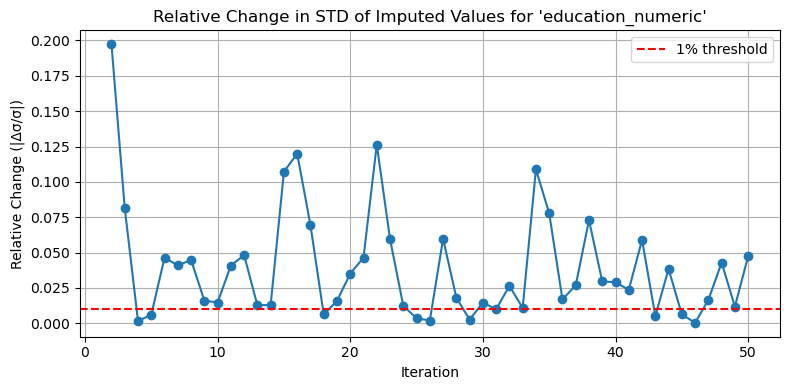

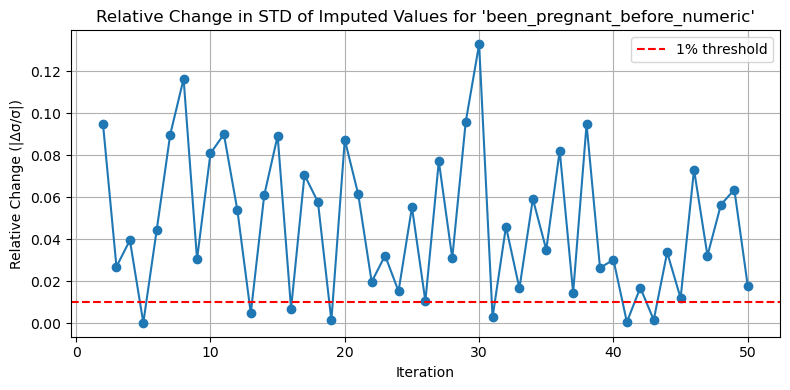

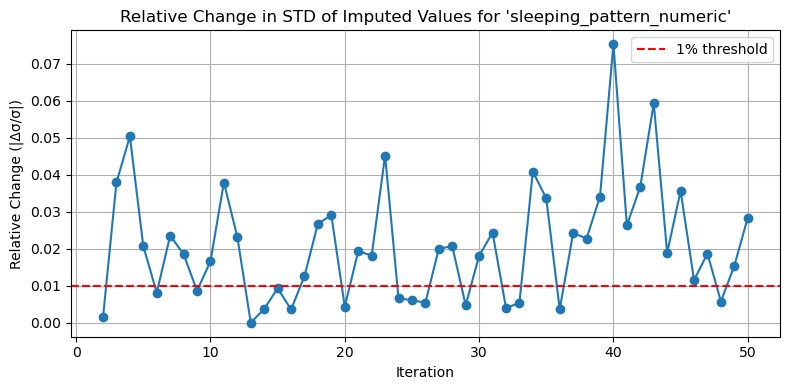

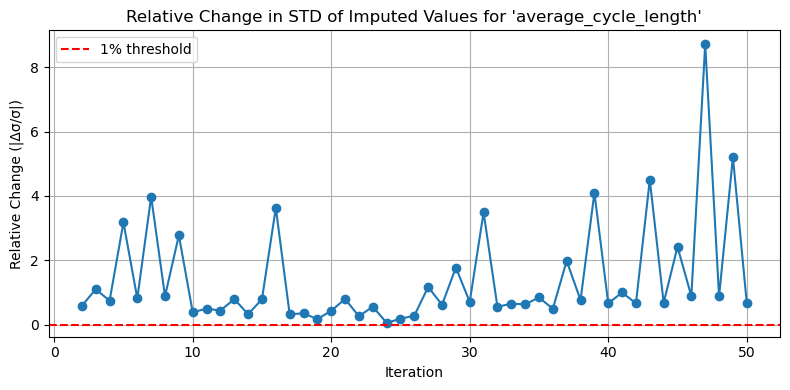

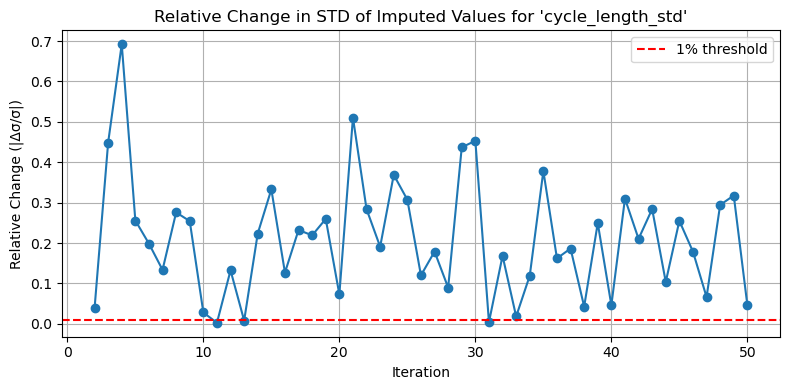

In [25]:
for col in features.columns:
    if features[col].isna().sum()>0:
        plot_relative_std_convergence(kernel, features, col)

In [26]:
# original
imputed_df[~mask]['education_numeric'].value_counts(normalize=True)

education_numeric
3.0    0.678928
4.0    0.116584
1.0    0.104738
2.0    0.091022
0.0    0.008728
Name: proportion, dtype: float64

In [27]:
imputed_df[mask]['education_numeric'].value_counts(normalize=True)

education_numeric
3.0    0.710997
2.0    0.107417
1.0    0.099744
4.0    0.074169
0.0    0.007673
Name: proportion, dtype: float64

In [28]:
# original
imputed_df[~mask]['been_pregnant_before_numeric'].value_counts(normalize=True)

been_pregnant_before_numeric
0.0    0.716329
1.0    0.176400
2.0    0.067342
3.0    0.039928
Name: proportion, dtype: float64

In [29]:
imputed_df[mask]['been_pregnant_before_numeric'].value_counts(normalize=True)

been_pregnant_before_numeric
0.0    0.621451
1.0    0.223975
2.0    0.126183
3.0    0.028391
Name: proportion, dtype: float64

In [30]:
been_pregnant_before_numeric_na_mask = imputed_df[~mask]['been_pregnant_before_numeric'].isna()

In [31]:
imputed_df['age'][been_pregnant_before_numeric_na_mask].describe()

count    317.000000
mean      32.340694
std        4.257237
min       22.000000
25%       29.000000
50%       32.000000
75%       35.000000
max       44.000000
Name: age, dtype: float64

In [32]:
imputed_df['age'][~been_pregnant_before_numeric_na_mask].describe()

count    1678.000000
mean       31.815256
std         4.021760
min        19.000000
25%        29.000000
50%        32.000000
75%        34.000000
max        44.000000
Name: age, dtype: float64

In [33]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

def compare_imputed_vs_observed(kernel, df_original, variable: str, dataset: int = 0,
                                 variable_type: str = 'continuous',
                                 output_folder: str = "../plots/",
                                 file_name: str = None,
                                 query_string: str = None,
                                 n_boot: int = 100):
    """
    Compare imputed vs observed distributions with CI and styled output.

    Parameters:
        - kernel: trained miceforest.ImputationKernel
        - df_original: raw DataFrame (with missing values)
        - variable: name of column to analyze
        - dataset: which completed dataset to pull from (default = 0)
        - variable_type: 'continuous' or 'categorical'
        - output_folder: directory to save the plot
        - file_name: override default filename (optional)
        - query_string: optional filtering of data before comparison
        - n_boot: number of bootstrap samples for CI (default = 100)
    """
    if variable not in df_original.columns:
        raise ValueError(f"'{variable}' not found in original dataframe.")
    if variable_type not in ["continuous", "categorical"]:
        raise ValueError("variable_type must be 'continuous' or 'categorical'")

    df_raw = df_original.copy()

    if query_string:
        try:
            df_raw = df_raw.query(query_string)
        except Exception as e:
            print(f"Invalid query string: {e}")
            return

    missing_idx = df_raw[df_raw[variable].isnull()].index
    observed_idx = df_raw[df_raw[variable].notnull()].index

    df_imputed = kernel.complete_data(dataset=dataset)
    imputed_vals = df_imputed.loc[missing_idx, variable].dropna()
    observed_vals = df_imputed.loc[observed_idx, variable].dropna()

    # Return early if no data
    if observed_vals.empty or imputed_vals.empty:
        print(f"Skipping '{variable}' – insufficient data after filtering or imputation.")
        return

    fig, ax = plt.subplots(figsize=(10, 5))

    if variable_type == "continuous":
        grid = np.linspace(
            min(df_imputed[variable].min(), observed_vals.min(), imputed_vals.min()),
            max(df_imputed[variable].max(), observed_vals.max(), imputed_vals.max()),
            100
        )

        def bootstrap_kde_ci(data, n_boot=100, grid=grid):
            kde_values = []
            for _ in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)
                kde = gaussian_kde(sample)
                kde_values.append(kde(grid))
            kde_values = np.array(kde_values)
            lower = np.percentile(kde_values, 2.5, axis=0)
            upper = np.percentile(kde_values, 97.5, axis=0)
            mean_kde = np.mean(kde_values, axis=0)
            return grid, mean_kde, lower, upper

        # Color scheme
        color_obs_line = "#277CB7"
        color_obs_fill = "#C6DCEC"
        color_imp_line = "#F28E2B"
        color_imp_fill = "#FDD9B5"

        # Observed
        x_obs, y_obs, low_obs, up_obs = bootstrap_kde_ci(observed_vals, n_boot, grid)
        ax.plot(x_obs, y_obs, label='Observed', color=color_obs_line)
        ax.fill_between(x_obs, low_obs, up_obs, color=color_obs_fill, alpha=1.0, label='Observed 95% CI')

        # Imputed
        x_imp, y_imp, low_imp, up_imp = bootstrap_kde_ci(imputed_vals, n_boot, grid)
        ax.plot(x_imp, y_imp, label='Imputed', color=color_imp_line)
        ax.fill_between(x_imp, low_imp, up_imp, color=color_imp_fill, alpha=1.0, label='Imputed 95% CI')

        ax.set_ylabel("Density")

    else:
        obs_freq = observed_vals.value_counts(normalize=True).sort_index()
        imp_freq = imputed_vals.value_counts(normalize=True).sort_index()
        categories = sorted(set(obs_freq.index).union(set(imp_freq.index)))

        obs_freq = obs_freq.reindex(categories, fill_value=0).sort_index()
        imp_freq = imp_freq.reindex(categories, fill_value=0).sort_index()

        obs_counts = observed_vals.value_counts().reindex(categories, fill_value=0).sort_index()
        imp_counts = imputed_vals.value_counts().reindex(categories, fill_value=0).sort_index()

        def binom_ci(p, n, z=1.96):
            se = np.sqrt(p * (1 - p) / n) if n > 0 else 0
            return p - z * se, p + z * se

        obs_ci = np.array([binom_ci(p, len(observed_vals)) for p in obs_freq])
        imp_ci = np.array([binom_ci(p, len(imputed_vals)) for p in imp_freq])

        x = np.arange(len(categories))
        width = 0.35

        obs_fill = "#C6DCEC"
        obs_edge = "#277CB7"
        imp_fill = "#FDD9B5"
        imp_edge = "#F28E2B"

        ax.bar(x - width / 2, obs_freq.values, width,
               yerr=[obs_freq.values - obs_ci[:, 0], obs_ci[:, 1] - obs_freq.values],
               capsize=5, label='Observed',
               color=obs_fill, edgecolor=obs_edge, linewidth=1.5)

        ax.bar(x + width / 2, imp_freq.values, width,
               yerr=[imp_freq.values - imp_ci[:, 0], imp_ci[:, 1] - imp_freq.values],
               capsize=5, label='Imputed',
               color=imp_fill, edgecolor=imp_edge, linewidth=1.5)

        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.set_ylabel("Relative Frequency")

    # Title
    title = f'Distribution of "{variable}": Observed vs Imputed'
    if query_string:
        title += f'\n[Filter: {query_string}]'
    ax.set_title(title, fontsize=14)

    # Styling
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()

    # File naming and saving
    os.makedirs(output_folder, exist_ok=True)
    if not file_name:
        safe_query = re.sub(r"[^\w\-]+", "_", query_string) if query_string else ""
        file_name = f"mf_{variable}__{safe_query}.jpg" if safe_query else f"mf_{variable}.jpg"
    output_path = os.path.join(output_folder, file_name)

    plt.savefig(output_path, format='jpg')
    plt.show()
    plt.close()
    print(f"Saved: {output_path}")


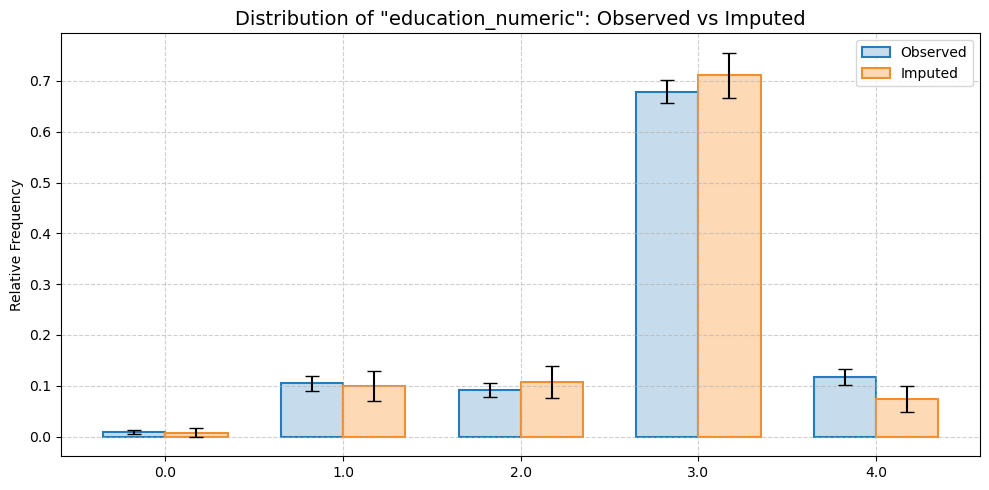

Plot saved to: ../plots/mf_education_numeric.jpg


In [34]:
compare_imputed_vs_observed(kernel, df, "education_numeric", variable_type="categorical")

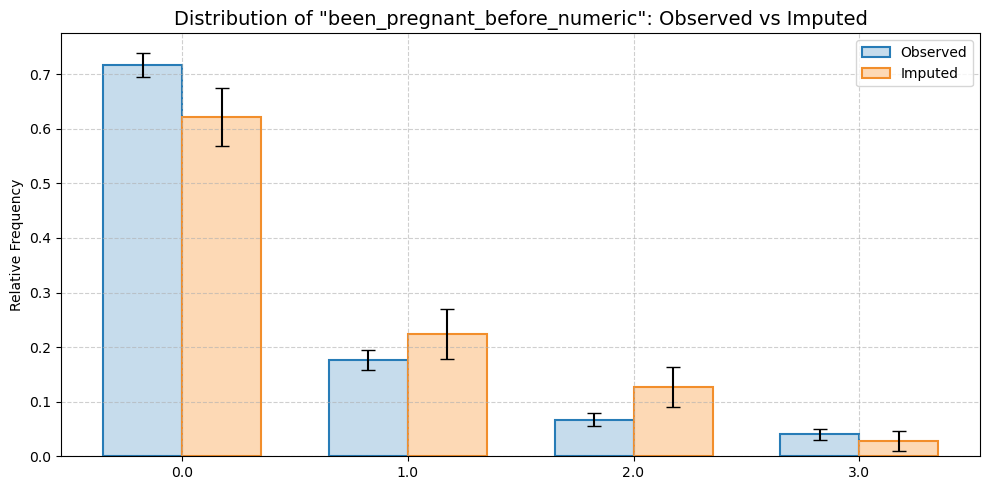

Plot saved to: ../plots/mf_been_pregnant_before_numeric.jpg


In [35]:
compare_imputed_vs_observed(kernel, df, "been_pregnant_before_numeric", variable_type="categorical")

In [36]:
features.columns

Index(['bmi', 'age', 'education_numeric', 'been_pregnant_before_numeric',
       'sleeping_pattern_numeric', 'average_cycle_length', 'cycle_length_std',
       'intercourse_frequency', 'dedication'],
      dtype='object')

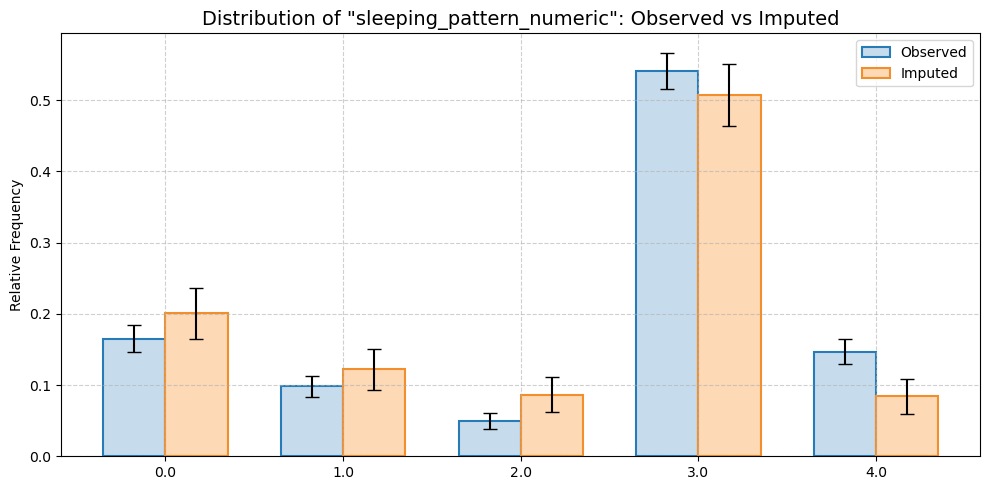

Plot saved to: ../plots/mf_sleeping_pattern_numeric.jpg


In [37]:
compare_imputed_vs_observed(kernel, df, "sleeping_pattern_numeric", variable_type="categorical")

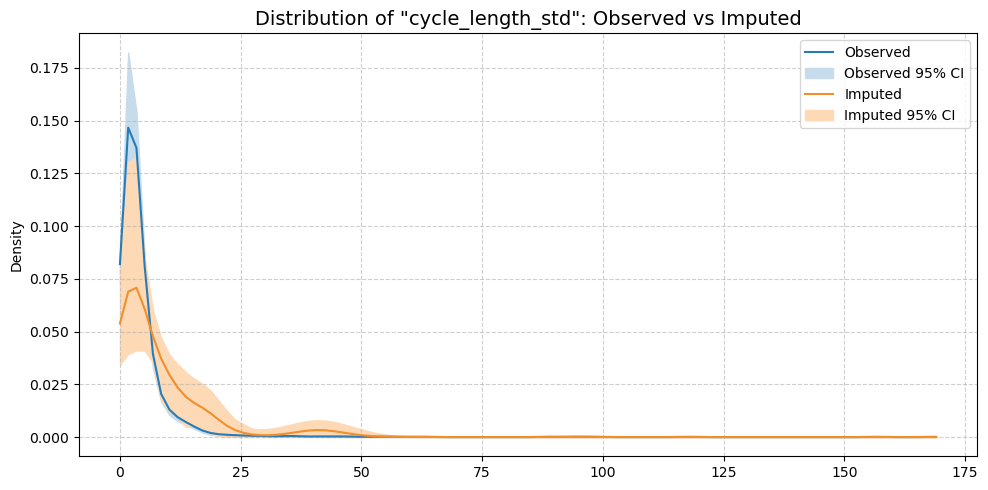

Plot saved to: ../plots/mf_cycle_length_std.jpg


In [38]:
compare_imputed_vs_observed(kernel, df, "cycle_length_std", variable_type="continuous")

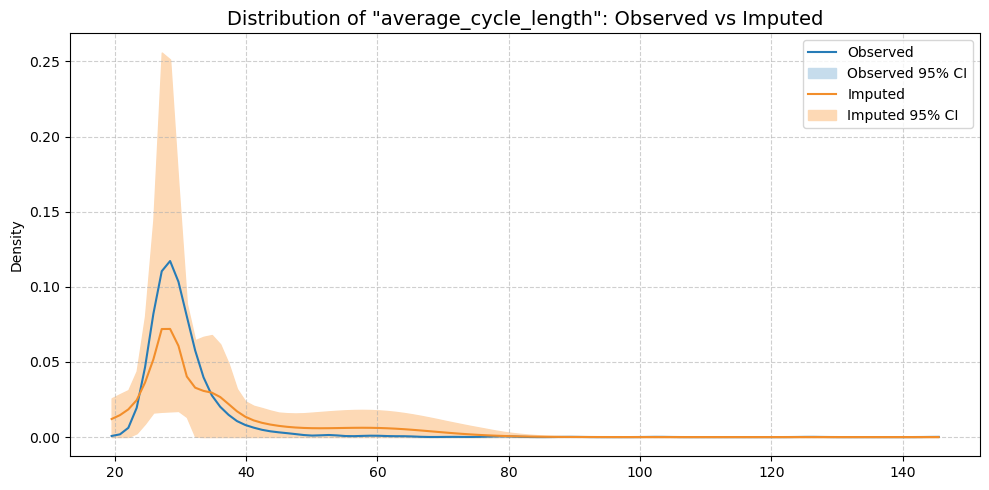

Plot saved to: ../plots/mf_average_cycle_length.jpg


In [39]:
compare_imputed_vs_observed(kernel, features, "average_cycle_length", variable_type="continuous")

In [40]:
imputed_df

,bmi,age,education_numeric,been_pregnant_before_numeric,sleeping_pattern_numeric,average_cycle_length,cycle_length_std,intercourse_frequency,dedication
0,22.942130,31,3.0,0.0,3.0,25.588235,2.526332,0.200000,0.640000
1,19.886054,34,3.0,1.0,3.0,30.875000,3.522884,0.052632,0.009569
2,29.323049,41,3.0,0.0,0.0,27.666667,2.503331,0.149123,0.298246
3,24.386526,27,1.0,0.0,3.0,24.250000,3.453776,0.145833,0.895833
4,29.299971,29,2.0,0.0,4.0,25.466667,0.990430,0.254902,0.666667
...,...,...,...,...,...,...,...,...,...
1990,24.867781,36,4.0,1.0,0.0,30.250000,2.061553,0.000000,0.000000
1991,21.616406,32,2.0,0.0,3.0,31.166667,2.483277,0.000000,0.843750
1992,24.218750,23,1.0,0.0,3.0,26.629630,1.620735,0.050467,0.540187
1993,21.453574,30,3.0,0.0,3.0,38.600000,41.126634,0.000000,0.000000


In [41]:
target_cols = ['n_cycles_trying', 'outcome_pregnant']
imputed_df[target_cols] = df[target_cols]

In [42]:
# Define reverse mappings
education_map = {v: k for k, v in {
    "Elementary school": 0,
    "High school": 1,
    "Trade/technical/vocational training": 2,
    "University": 3,
    "PhD": 4
}.items()}

sleeping_map = {v: k for k, v in {
    "Several times during the night": 0,
    "Shift worker": 1,
    "Late and snoozer": 2,
    "Wake same every workday": 3,
    "Wake same every day": 4
}.items()}

pregnancy_map = {v: k for k, v in {
    "No, never": 0,
    "Yes, once": 1,
    "Yes, twice": 2,
    "Yes 3 times or more": 3
}.items()}

# Map numeric columns back to strings
imputed_df['education'] = imputed_df['education_numeric'].map(education_map)
imputed_df['sleeping_pattern'] = imputed_df['sleeping_pattern_numeric'].map(sleeping_map)
imputed_df['been_pregnant_before'] = imputed_df['been_pregnant_before_numeric'].map(pregnancy_map)


In [43]:
# === 1. Boolean recoding based on categorical values ===

# Define mappings
university_education = {
    "Elementary school": False,
    "High school": False,
    "Trade/technical/vocational training": False,
    "University": True,
    "PhD": True
}

regular_sleep = {
    "Several times during the night": False,
    "Shift worker": False,
    "Late and snoozer": False,
    "Wake same every workday": True,
    "Wake same every day": True
}

pregnancy_binary = {
    "No, never": False,
    "Yes, once": True,
    "Yes, twice": True,
    "Yes 3 times or more": True
}

# Apply to imputed_df
imputed_df['university_education'] = imputed_df['education'].map(university_education)
imputed_df['regular_sleep'] = imputed_df['sleeping_pattern'].map(regular_sleep)
imputed_df['been_pregnant_before_binary'] = imputed_df['been_pregnant_before'].map(pregnancy_binary)

# === 2. Derived groupings from numerical columns ===

# Cycle regularity: std < 5 is regular
imputed_df['regular_cycle'] = imputed_df['cycle_length_std'] < 5

# Age groups
def categorize_age(age):
    if pd.isna(age):
        return pd.NA
    elif age <= 29:
        return '19-29'
    elif age <= 35:
        return '30-35'
    else:
        return '35-44'

# Intercourse frequency
def categorize_intercourse_frequency(freq):
    if pd.isna(freq):
        return pd.NA
    elif freq <= 0.02:
        return 'low'
    elif freq <= 0.162:
        return 'medium'
    else:
        return 'high'

# Dedication to app
def categorize_dedication(ded):
    if pd.isna(ded):
        return pd.NA
    elif ded <= 0.133:
        return 'low'
    elif ded <= 0.781:
        return 'medium'
    else:
        return 'high'

# BMI group using WHO cutoffs
def categorize_bmi(bmi):
    if pd.isna(bmi):
        return pd.NA
    elif bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    else:
        return 'overweight'

# Average cycle length group
def categorize_cycle_length(length):
    if pd.isna(length):
        return pd.NA
    elif length < 21 or length > 35:
        return '<21 OR >35'
    else:
        return '21-35'

# Apply groupings
imputed_df['age_group'] = imputed_df['age'].apply(categorize_age)
imputed_df['intercourse_frequency_group'] = imputed_df['intercourse_frequency'].apply(categorize_intercourse_frequency)
imputed_df['dedication_group'] = imputed_df['dedication'].apply(categorize_dedication)
imputed_df['bmi_group'] = imputed_df['bmi'].apply(categorize_bmi)
imputed_df['average_cycle_length_group'] = imputed_df['average_cycle_length'].apply(categorize_cycle_length)


In [44]:
columns_small = ['n_cycles_trying', 'outcome_pregnant', 
               'age_group','bmi_group',
               'been_pregnant_before_binary', 
               'average_cycle_length_group', 'regular_cycle',
               'university_education', 'regular_sleep',
               'intercourse_frequency_group', 'dedication_group']
imputed_df_small = imputed_df[columns_small].copy()

In [45]:
imputed_df_small.isna().sum()

n_cycles_trying                0
outcome_pregnant               0
age_group                      0
bmi_group                      0
been_pregnant_before_binary    0
average_cycle_length_group     0
regular_cycle                  0
university_education           0
regular_sleep                  0
intercourse_frequency_group    0
dedication_group               0
dtype: int64

In [46]:
imputed_df_small.to_csv('../data/modified_small_imputed.csv', index=False)